In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22-angle-update...
✅ Data úspěšně načtena.
  -> Celkový počet vzorků: 5208
  -> Input Shape (Měření): torch.Size([5208, 4]) ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]
  -> Target Shape (GT):    torch.Size([5208, 4]) ... [PX, VX, PY, VY]


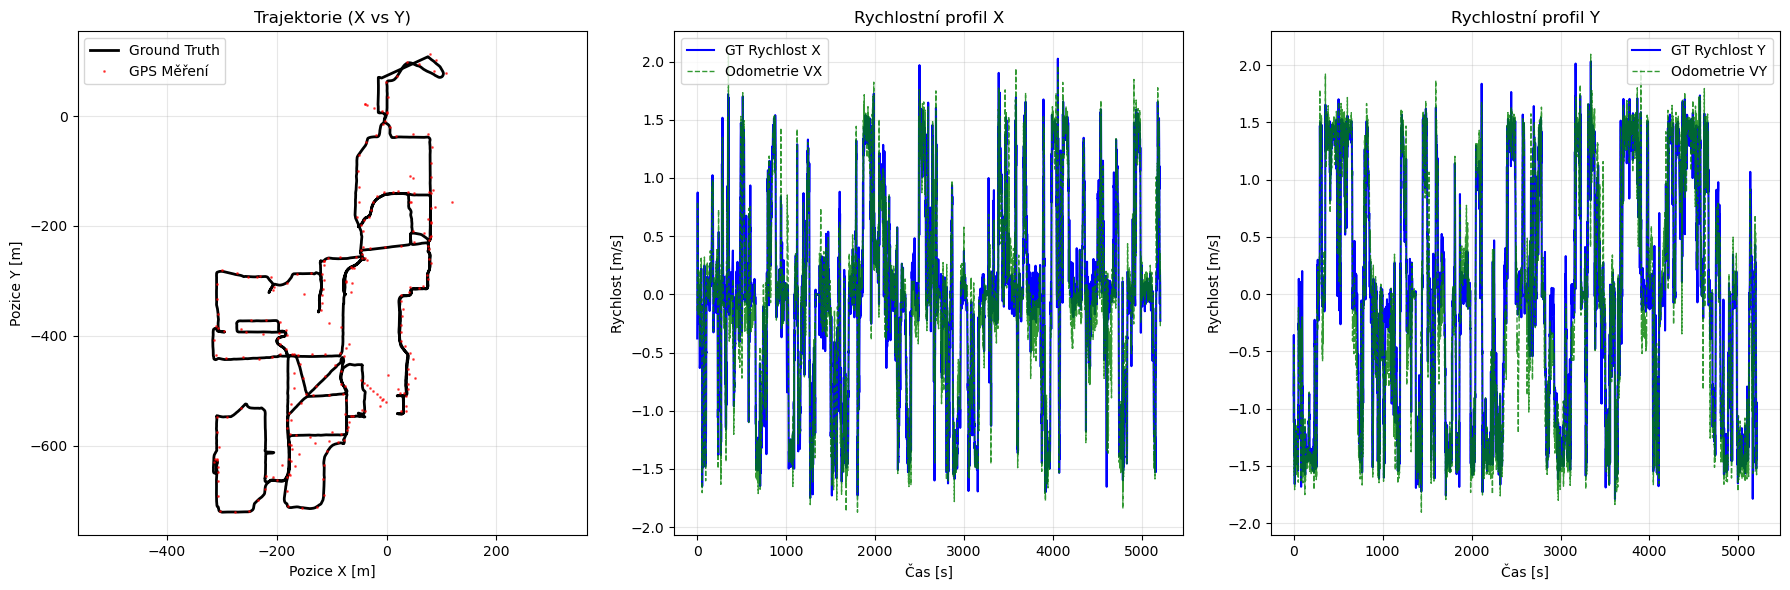

In [3]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. KONFIGURACE ===
# Cesta k adresáři, který vytvořil preprocess skript
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22-angle-update'

print(f"Načítám data z: {data_dir}...")

try:
    # === 2. NAČTENÍ DAT (.pt soubory) ===
    # Data jsou uložena jako list slovníků [{'ground_truth': ..., 'filtered_gps': ...}]
    # filtered_gps zde ale obsahuje náš 4D vektor [GPS_X, ODO_VX, GPS_Y, ODO_VY]
    
    train_data = torch.load(os.path.join(data_dir, 'train.pt'))
    val_data = torch.load(os.path.join(data_dir, 'val.pt'))
    test_data = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů (předpokládáme 1 trajektorii v listu)
    X_train, Y_train = train_data[0]['ground_truth'], train_data[0]['filtered_gps']
    X_val, Y_val     = val_data[0]['ground_truth'],   val_data[0]['filtered_gps']
    X_test, Y_test   = test_data[0]['ground_truth'],  test_data[0]['filtered_gps']

    # Spojení zpět do jedné sekvence pro vizualizaci celé trajektorie
    X_full = torch.cat([X_train, X_val, X_test], dim=0)
    Y_full = torch.cat([Y_train, Y_val, Y_test], dim=0)

    print(f"✅ Data úspěšně načtena.")
    print(f"  -> Celkový počet vzorků: {X_full.shape[0]}")
    print(f"  -> Input Shape (Měření): {Y_full.shape} ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]")
    print(f"  -> Target Shape (GT):    {X_full.shape} ... [PX, VX, PY, VY]")

    # === 3. VIZUALIZACE ===
    # Převedeme na numpy pro matplotlib
    gt_np = X_full.numpy()
    meas_np = Y_full.numpy()
    time_steps = np.arange(len(gt_np)) # Předpoklad 1Hz (DT=1.0)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # --- A) Trajektorie (X-Y) ---
    # Ground Truth (Sloupce 0 a 2 v Targetu)
    ax[0].plot(gt_np[:, 0], gt_np[:, 2], 'k-', linewidth=2, label='Ground Truth')
    
    # GPS Měření (Sloupce 0 a 2 v Inputu)
    # Vykreslíme jen každý 20. bod, aby graf nebyl přeplácaný
    ax[0].plot(meas_np[::20, 0], meas_np[::20, 2], 'r.', markersize=2, alpha=0.6, label='GPS Měření')

    ax[0].set_title('Trajektorie (X vs Y)')
    ax[0].set_xlabel('Pozice X [m]')
    ax[0].set_ylabel('Pozice Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- B) Rychlost X (VX) ---
    # GT Rychlost (Sloupec 1 v Targetu)
    ax[1].plot(time_steps, gt_np[:, 1], 'b-', linewidth=1.5, label='GT Rychlost X')
    # ODO Rychlost (Sloupec 1 v Inputu)
    ax[1].plot(time_steps, meas_np[:, 1], 'g--', linewidth=1, alpha=0.8, label='Odometrie VX')

    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].set_ylabel('Rychlost [m/s]')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # --- C) Rychlost Y (VY) ---
    # GT Rychlost (Sloupec 3 v Targetu)
    ax[2].plot(time_steps, gt_np[:, 3], 'b-', linewidth=1.5, label='GT Rychlost Y')
    # ODO Rychlost (Sloupec 3 v Inputu)
    ax[2].plot(time_steps, meas_np[:, 3], 'g--', linewidth=1, alpha=0.8, label='Odometrie VY')

    ax[2].set_title('Rychlostní profil Y')
    ax[2].set_xlabel('Čas [s]')
    ax[2].set_ylabel('Rychlost [m/s]')
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Adresář '{data_dir}' nebo soubory .pt nenalezeny.")
    print("Spustil jsi předtím skript 'preprocess_NCLT_trajectory_linear_test.py'?")
except Exception as e:
    print(f"❌ CHYBA: {e}")

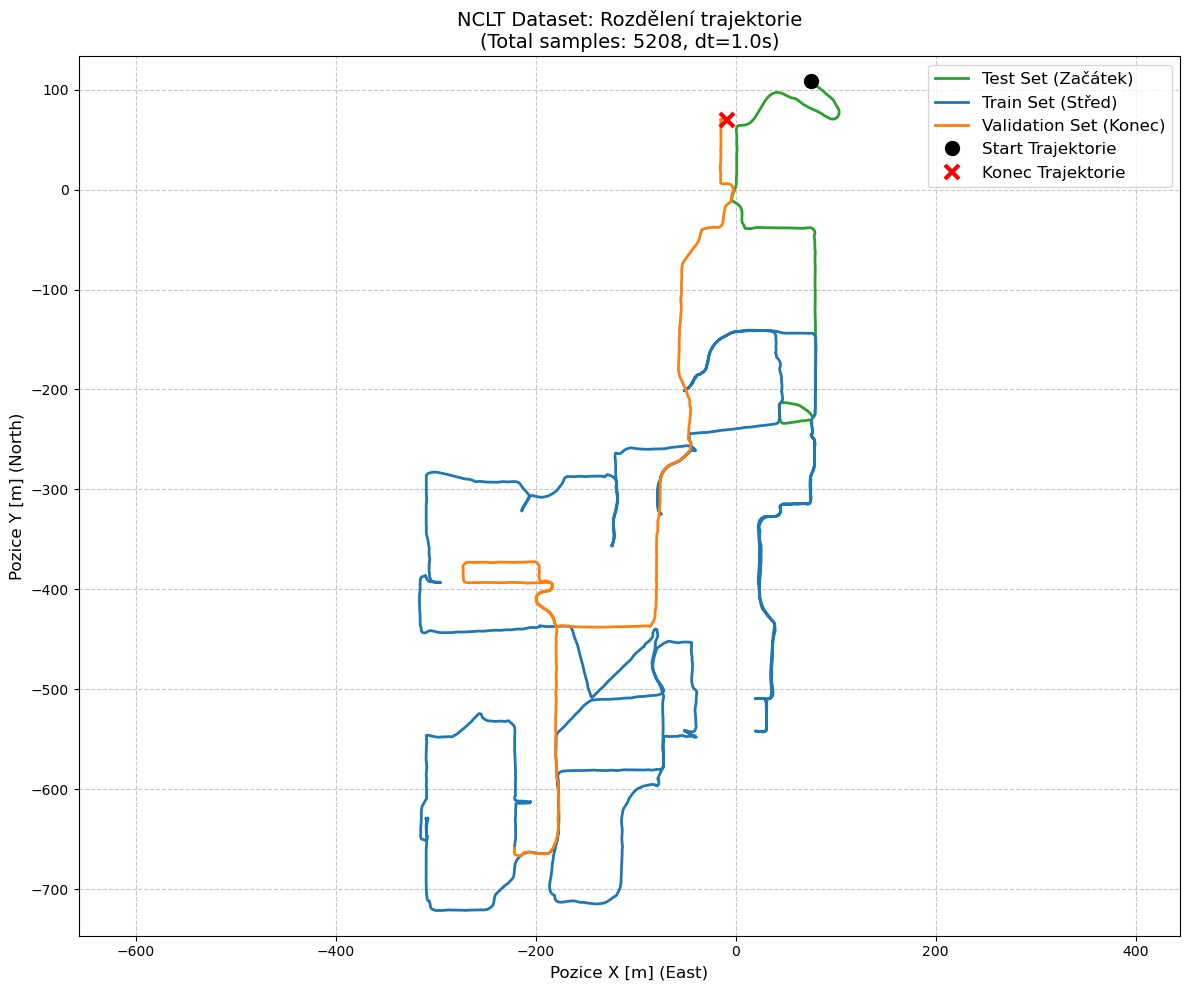

In [4]:
import matplotlib.pyplot as plt

# === VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# Používáme proměnné z předchozího kroku: X_train, X_val, X_test
# Konverze .numpy() funguje, pokud jsou tensory na CPU (což po načtení torch.load obvykle jsou)

# 1. Testovací část (Podle tvého 'save_splits' je Test na začátku - prvních cca 10%)
plt.plot(X_test[:, 0].numpy(), 
         X_test[:, 2].numpy(), 
         label='Test Set (Začátek)', color='#2ca02c', linewidth=2) # Zelená

# 2. Trénovací část (Navazuje na Test - středních 70%)
plt.plot(X_train[:, 0].numpy(), 
         X_train[:, 2].numpy(), 
         label='Train Set (Střed)', color='#1f77b4', linewidth=2) # Modrá

# 3. Validační část (Navazuje na Train - koncových 20%)
plt.plot(X_val[:, 0].numpy(), 
         X_val[:, 2].numpy(), 
         label='Validation Set (Konec)', color='#ff7f0e', linewidth=2) # Oranžová

# Zvýraznění začátku a konce celé trajektorie
# Začátek je v prvním bodě Testovací sady
plt.plot(X_test[0, 0], X_test[0, 2], 'ko', markersize=10, label='Start Trajektorie')

# Konec je v posledním bodě Validační sady
plt.plot(X_val[-1, 0], X_val[-1, 2], 'rx', markersize=10, markeredgewidth=3, label='Konec Trajektorie')

# Formátování grafu
# N_samples a DT vezmeme z kontextu předchozího cellu nebo definujeme
N_samples = X_full.shape[0] 
DT = 1.0 

plt.title(f'NCLT Dataset: Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [5]:
import torch
import math
import Systems 

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################
### Design Parameters ###
### (OPTIMALIZOVANÉ)  ###
#########################

# 1. Rozměry
# Stav: [px, vx, py, vy]
m = 4 
n = 4 
delta_t = 1.0 

# 2. Dynamika (F)
# x_{t+1} = x_t + v_t * dt
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H)
H_design = torch.eye(n).float()

# ==========================================
# 4. Šum procesu (Q) - OPTIMALIZOVÁNO
# ==========================================
# Hodnota z Optuny (MSE ~760)
q_scale = 0.00006806

# Používáme kinematický model (Discrete White Noise Acceleration), 
# který byl použit v optimalizačním skriptu.
# Blok pro jednu dimenzi (pozice + rychlost):
Q_block_val = torch.tensor([
    [(delta_t**3)/3, (delta_t**2)/2],
    [(delta_t**2)/2,  delta_t      ]
]) * q_scale

# Výsledná Q pro [px, vx, py, vy]
Q_design = torch.block_diag(Q_block_val, Q_block_val).float()


# ==========================================
# 5. Šum měření (R) - OPTIMALIZOVÁNO
# ==========================================
# Hodnoty z Optuny
var_gps = 38.370833  # Vysoká nedůvěra v GPS (odpovídá realitě NCLT)
var_odo = 0.000560   # Extrémní důvěra v Odometrii

# Pořadí stavů: [Pos_X, Vel_X, Pos_Y, Vel_Y]
# Takže střídáme: [GPS, ODO, GPS, ODO]
R_design = torch.tensor([
    [var_gps, 0.0,     0.0,     0.0],
    [0.0,     var_odo, 0.0,     0.0],
    [0.0,     0.0,     var_gps, 0.0],
    [0.0,     0.0,     0.0,     var_odo]
]).float()

# 6. Počáteční podmínky
m1x_0 = torch.zeros(m, 1).float()
m2x_0 = torch.eye(m).float() * 1.0 # Zvýšena počáteční nejistota, aby se filtr rychleji chytil

print("\nInicializuji systém dle OPTIMALIZOVANÝCH parametrů (NCLT)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"Q scale: {q_scale}")
print(f"R diagonal: {torch.diagonal(R_design)}")

# === INICIALIZACE SYSTÉMŮ ===

sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].")


Inicializuji systém dle OPTIMALIZOVANÝCH parametrů (NCLT)...
Dimenze stavu: 4, Dimenze měření: 4
Q scale: 6.806e-05
R diagonal: tensor([3.8371e+01, 5.6000e-04, 3.8371e+01, 5.6000e-04])
... Systémy inicializovány.
POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# === 1. KONFIGURACE ===
# Dynamicky zjistíme délku testovací sady z proměnné X_test (kterou máme z minula)
# Pokud by X_test neexistovalo, kód spadne, ale to by znamenalo, že jsi nenačetl data.
TEST_SEQ_LEN = X_test.shape[0] 

TRAIN_SEQ_LEN = 50    # Délka sekvence pro trénink (krátká okna)
VAL_SEQ_LEN = 200     # Validace po delších úsecích
STRIDE = 10           # Posun okna (překryv)
BATCH_SIZE = 128      # Velikost dávky

def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory [Total_Len, Dim] na sekvence [N_seq, Seq_Len, Dim].
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    # Pokud je seq_len větší než data (např. u testu), vezmeme prostě to, co máme
    if seq_len > num_samples:
        seq_len = num_samples
    
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        # Fallback: Pokud by data byla kratší než seq_len, vrátíme prázdné nebo 1 kus
        return X.unsqueeze(0), Y.unsqueeze(0)
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    """
    Filtruje sekvence, které obsahují jakékoliv NaN nebo Inf hodnoty.
    """
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Zkontrolujeme NaN/Inf pro každou sekvenci zvlášť
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí (NaN/Inf). Zbývá: {len(X_clean)}")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("--- ZPRACOVÁNÍ DAT ---")

# === 2. TVORBA SEKVENCÍ A PŘETYPOVÁNÍ ===
# OPRAVA PROMĚNNÝCH: Používáme X_train, Y_train atd. místo train_target/input
# X = Ground Truth, Y = Měření (Input)
print(f"Generuji sekvence (Test délka: {TEST_SEQ_LEN})...")

# Train: Krátká okna s překryvem
train_X_raw, train_Y_raw = create_sequences(X_train.float(), Y_train.float(), TRAIN_SEQ_LEN, STRIDE)

# Val: Delší okna (bez překryvu)
val_X_raw, val_Y_raw = create_sequences(X_val.float(), Y_val.float(), VAL_SEQ_LEN, VAL_SEQ_LEN)

# Test: Jedna dlouhá sekvence (pro kontinuální vyhodnocení)
# Stride = TEST_SEQ_LEN zajistí, že dostaneme právě jeden (nebo málo) dlouhých kusů
test_X_raw, test_Y_raw = create_sequences(X_test.float(), Y_test.float(), TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT (NAN/INF FILTER) ===
print("\nFiltruji NaN hodnoty...")
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")
# Train: Shuffle=True (Důležité pro trénink)
train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val/Test: Shuffle=False (Abychom viděli průběh)
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
# Pro test batch_size=1, protože máme jednu obří sekvenci (nebo pár velkých)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\n✅ HOTOVO. Připraveno k tréninku.")
print(f"Train batches: {len(train_loader)} (Batch shape: {next(iter(train_loader))[0].shape})")
print(f"Test batches:  {len(test_loader)} (Seq len: {test_X_seq.shape[1]})")

--- ZPRACOVÁNÍ DAT ---
Generuji sekvence (Test délka: 522)...

Filtruji NaN hodnoty...
✅ Train: Data jsou čistá. (360 sekvencí)
✅ Val: Data jsou čistá. (5 sekvencí)
✅ Test: Data jsou čistá. (1 sekvencí)

Vytvářím DataLoadery...

✅ HOTOVO. Připraveno k tréninku.
Train batches: 3 (Batch shape: torch.Size([128, 50, 4]))
Test batches:  1 (Seq len: 522)


In [7]:
import torch
import torch.optim as optim
import os
from state_NN_models import StateBayesianKalmanNet,StateKalmanNet
from utils import trainer

state_bkn = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10,
                                   output_layer_multiplier=4,num_gru_layers=1,
                                    init_max_dropout=0.3,init_min_dropout=0.1, norm_states=True).to(device)

print(state_bkn)


state_knet = state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=8,
                                         output_layer_multiplier=4,num_gru_layers=1,
                                         gru_hidden_dim_multiplier=4,
                                         returns_covariance=True).to(device)
print(state_knet)


INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNet(
  (dnn): DNN_BayesianKalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 128)
    (output_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
    (concrete_dropout2): ConcreteDropout()
  )
)
DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
    )
    (gru): GRU(512, 128)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
  

In [8]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'NN_weights'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'KalmanNet_test.pth' #best_MSE_KalmanNet_linear_trajectory
BKN_FILENAME = 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'  

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

print("\n--- Hotovo ---")

--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/NCL_linear_model_test/NN_weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'KalmanNet_test.pth'.
✅ State BKN: Váhy úspěšně načteny z 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'.

--- Hotovo ---


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Tvůj modul s filtry
from utils import utils # Tvůj modul pro ANEES

# ==============================================================================
# 0. KONFIGURACE
# ==============================================================================
J_SAMPLES = 50  # Počet vzorků pro Monte Carlo Dropout (Ensemble)

# 1. Příprava BKN modelu (Bayesian)
try:
    trained_model_bkn = state_bkn
    # DŮLEŽITÉ: Pro BKN musí být model v režimu TRAIN (aby fungoval Dropout)
    trained_model_bkn.train() 
    print(f"INFO: Bayesian KalmanNet (BKN) připraven (J={J_SAMPLES}).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_knet' (BKN) neexistuje.")

# 2. Příprava KalmanNet modelu (Classic)
try:
    # Předpokládám, že klasický KalmanNet máš v proměnné 'state_knet_classic'
    # Pokud používáš stejnou třídu, jen bez dropoutu, změň název proměnné dle potřeby.
    trained_model_classic = state_knet 
    trained_model_classic.eval() # Klasický KNet chceme v eval módu (vypnout dropout, pokud tam je)
    print(f"INFO: KalmanNet (Classic) připraven.")
except NameError:
    print("VAROVÁNÍ: Proměnná 'state_knet_classic' nenalezena. KNet bude přeskočen.")
    trained_model_classic = None

# 3. Inicializace klasických filtrů
print("Inicializuji EKF, UKF, PF, AKF, KF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=1000000) # Sníženo pro rychlost
akf_filter = Filters.AdaptiveKalmanFilter_online(sys_model, mdm_L=3, mdm_version=1, forgetting_factor=0.995)
kf_filter = Filters.KalmanFilter(sys_model)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Slovník pro ukládání výsledků (jednodušší než seznamy seznamů)
results = {
    'BKN':  {'mse': [], 'anees': []},
    'KNet': {'mse': [], 'anees': []},
    'EKF':  {'mse': [], 'anees': []},
    'UKF':  {'mse': [], 'anees': []},
    'PF':   {'mse': [], 'anees': []},
    'AKF':  {'mse': [], 'anees': []},
    'KF':   {'mse': [], 'anees': []}
}

traj_idx = 0
total_trajectories = len(test_loader.dataset)
state_dim = sys_model.state_dim

print(f"\nVyhodnocuji {total_trajectories} sekvencí z testovací sady...")

with torch.no_grad():
    for x_true_batch, y_meas_batch in test_loader:
        
        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Příprava dat pro jednu trajektorii
            y_seq = y_meas_batch[i].to(device)    # [Seq_Len, Obs_Dim]
            x_true = x_true_batch[i].to(device)   # [Seq_Len, State_Dim]
            seq_len = y_seq.shape[0]

            # Inicializační stavy
            knet_init_state = x_true[0, :].unsqueeze(0) # [1, Dim]
            filter_init_state = x_true[0, :].unsqueeze(1) # [Dim, 1]

            # ==================================================================
            # 1. Bayesian KalmanNet (Ensemble)
            # ==================================================================
            ensemble_preds = []
            
            for j in range(J_SAMPLES):
                trained_model_bkn.reset(batch_size=1, initial_state=knet_init_state)
                sample_seq = [knet_init_state] 
                
                for t in range(1, seq_len):
                    y_t = y_seq[t, :].unsqueeze(0)
                    x_val, _ = trained_model_bkn.step(y_t) 
                    sample_seq.append(x_val)
                ensemble_preds.append(torch.cat(sample_seq, dim=0))
            
            # Statistiky BKN
            ensemble_tensor = torch.stack(ensemble_preds, dim=0) # [J, T, Dim]
            x_hat_bkn = ensemble_tensor.mean(dim=0) 
            P_diag_bkn = ensemble_tensor.var(dim=0) + 1e-9 # Epistemická variance
            
            # Konstrukce plné P pro ANEES
            full_P_hat_bkn = torch.zeros(seq_len, state_dim, state_dim, device=device)
            for t_step in range(seq_len):
                full_P_hat_bkn[t_step] = torch.diag(P_diag_bkn[t_step])

            results['BKN']['mse'].append(F.mse_loss(x_hat_bkn[1:], x_true[1:]).item())
            results['BKN']['anees'].append(utils.calculate_anees_vectorized(x_true, x_hat_bkn, full_P_hat_bkn))

            # ==================================================================
            # 2. Deterministický KalmanNet (KNet)
            # ==================================================================
            if trained_model_classic is not None:
                trained_model_classic.reset(batch_size=1, initial_state=knet_init_state)
                knet_preds = [knet_init_state]
                knet_covs = [sys_model.P0.unsqueeze(0)] # P0 pro t=0
                
                for t in range(1, seq_len):
                    y_t = y_seq[t, :].unsqueeze(0)
                    # Očekáváme, že step vrací (x, P) nebo jen x
                    out = trained_model_classic.step(y_t)
                    if isinstance(out, tuple):
                        x_val, P_val = out
                    else:
                        x_val, P_val = out, sys_model.P0.unsqueeze(0) # Fallback P0
                    
                    knet_preds.append(x_val)
                    knet_covs.append(P_val)
                
                x_hat_knet = torch.cat(knet_preds, dim=0)
                P_hat_knet = torch.cat(knet_covs, dim=0)
                
                results['KNet']['mse'].append(F.mse_loss(x_hat_knet[1:], x_true[1:]).item())
                results['KNet']['anees'].append(utils.calculate_anees_vectorized(x_true, x_hat_knet, P_hat_knet))

            # ==================================================================
            # 3. Klasické Filtry
            # ==================================================================
            
            # Helper pro uložení výsledků filtru
            def save_filter_res(name, res_dict):
                if res_dict is None: return # Skip failed filter
                x_filt = res_dict['x_filtered']
                P_filt = res_dict['P_filtered']
                results[name]['mse'].append(F.mse_loss(x_filt[1:], x_true[1:]).item())
                results[name]['anees'].append(utils.calculate_anees_vectorized(x_true, x_filt, P_filt))

            # Adaptive KF
            try:
                res_akf, _, _ = akf_filter.process_sequence_adaptively(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
                save_filter_res('AKF', res_akf)
            except:
                pass # AKF občas diverguje

            # Standard KF
            res_kf = kf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('KF', res_kf)

            # EKF
            res_ekf = ekf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('EKF', res_ekf)

            # UKF
            res_ukf = ukf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('UKF', res_ukf)

            # PF
            res_pf = pf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('PF', res_pf)

            if traj_idx % 20 == 0:
                print(f"  -> Zpracováno {traj_idx}/{total_trajectories}")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(lst): return np.mean(lst) if len(lst) > 0 else np.nan

print("\n" + "="*100)
print(f"FINÁLNÍ VÝSLEDKY: KOMPLEXNÍ SROVNÁNÍ (MSE a ANEES)")
print("="*100)
print(f"{'Model':<30} | {'Průměrné MSE':<20} | {'RMSE [m]':<20} | {'Průměrný ANEES':<20}")
print("-" * 100)
print(f"Cílové ANEES ≈ {state_dim:.2f}")
print("-" * 100)

models_list = ['BKN', 'KNet', 'AKF', 'KF', 'EKF', 'UKF', 'PF']
# Odebereme KNet, pokud nebyl načten
if trained_model_classic is None: 
    models_list.remove('KNet')

for m_name in models_list:
    mse_val = avg(results[m_name]['mse'])
    anees_val = avg(results[m_name]['anees'])
    rmse_val = np.sqrt(mse_val)
    
    print(f"{m_name:<30} | {mse_val:<20.4f} | {rmse_val:<20.4f} | {anees_val:<20.4f}")

print("="*100)

INFO: Bayesian KalmanNet (BKN) připraven (J=50).
INFO: KalmanNet (Classic) připraven.
Inicializuji EKF, UKF, PF, AKF, KF...

Vyhodnocuji 1 sekvencí z testovací sady...
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na u

/tmp/ipykernel_83070/808934896.py:72: RuntimeWarning: invalid value encountered in sqrt
  knet_std_np = np.sqrt(torch.cat(knet_vars, dim=0).numpy()) # Už je na CPU


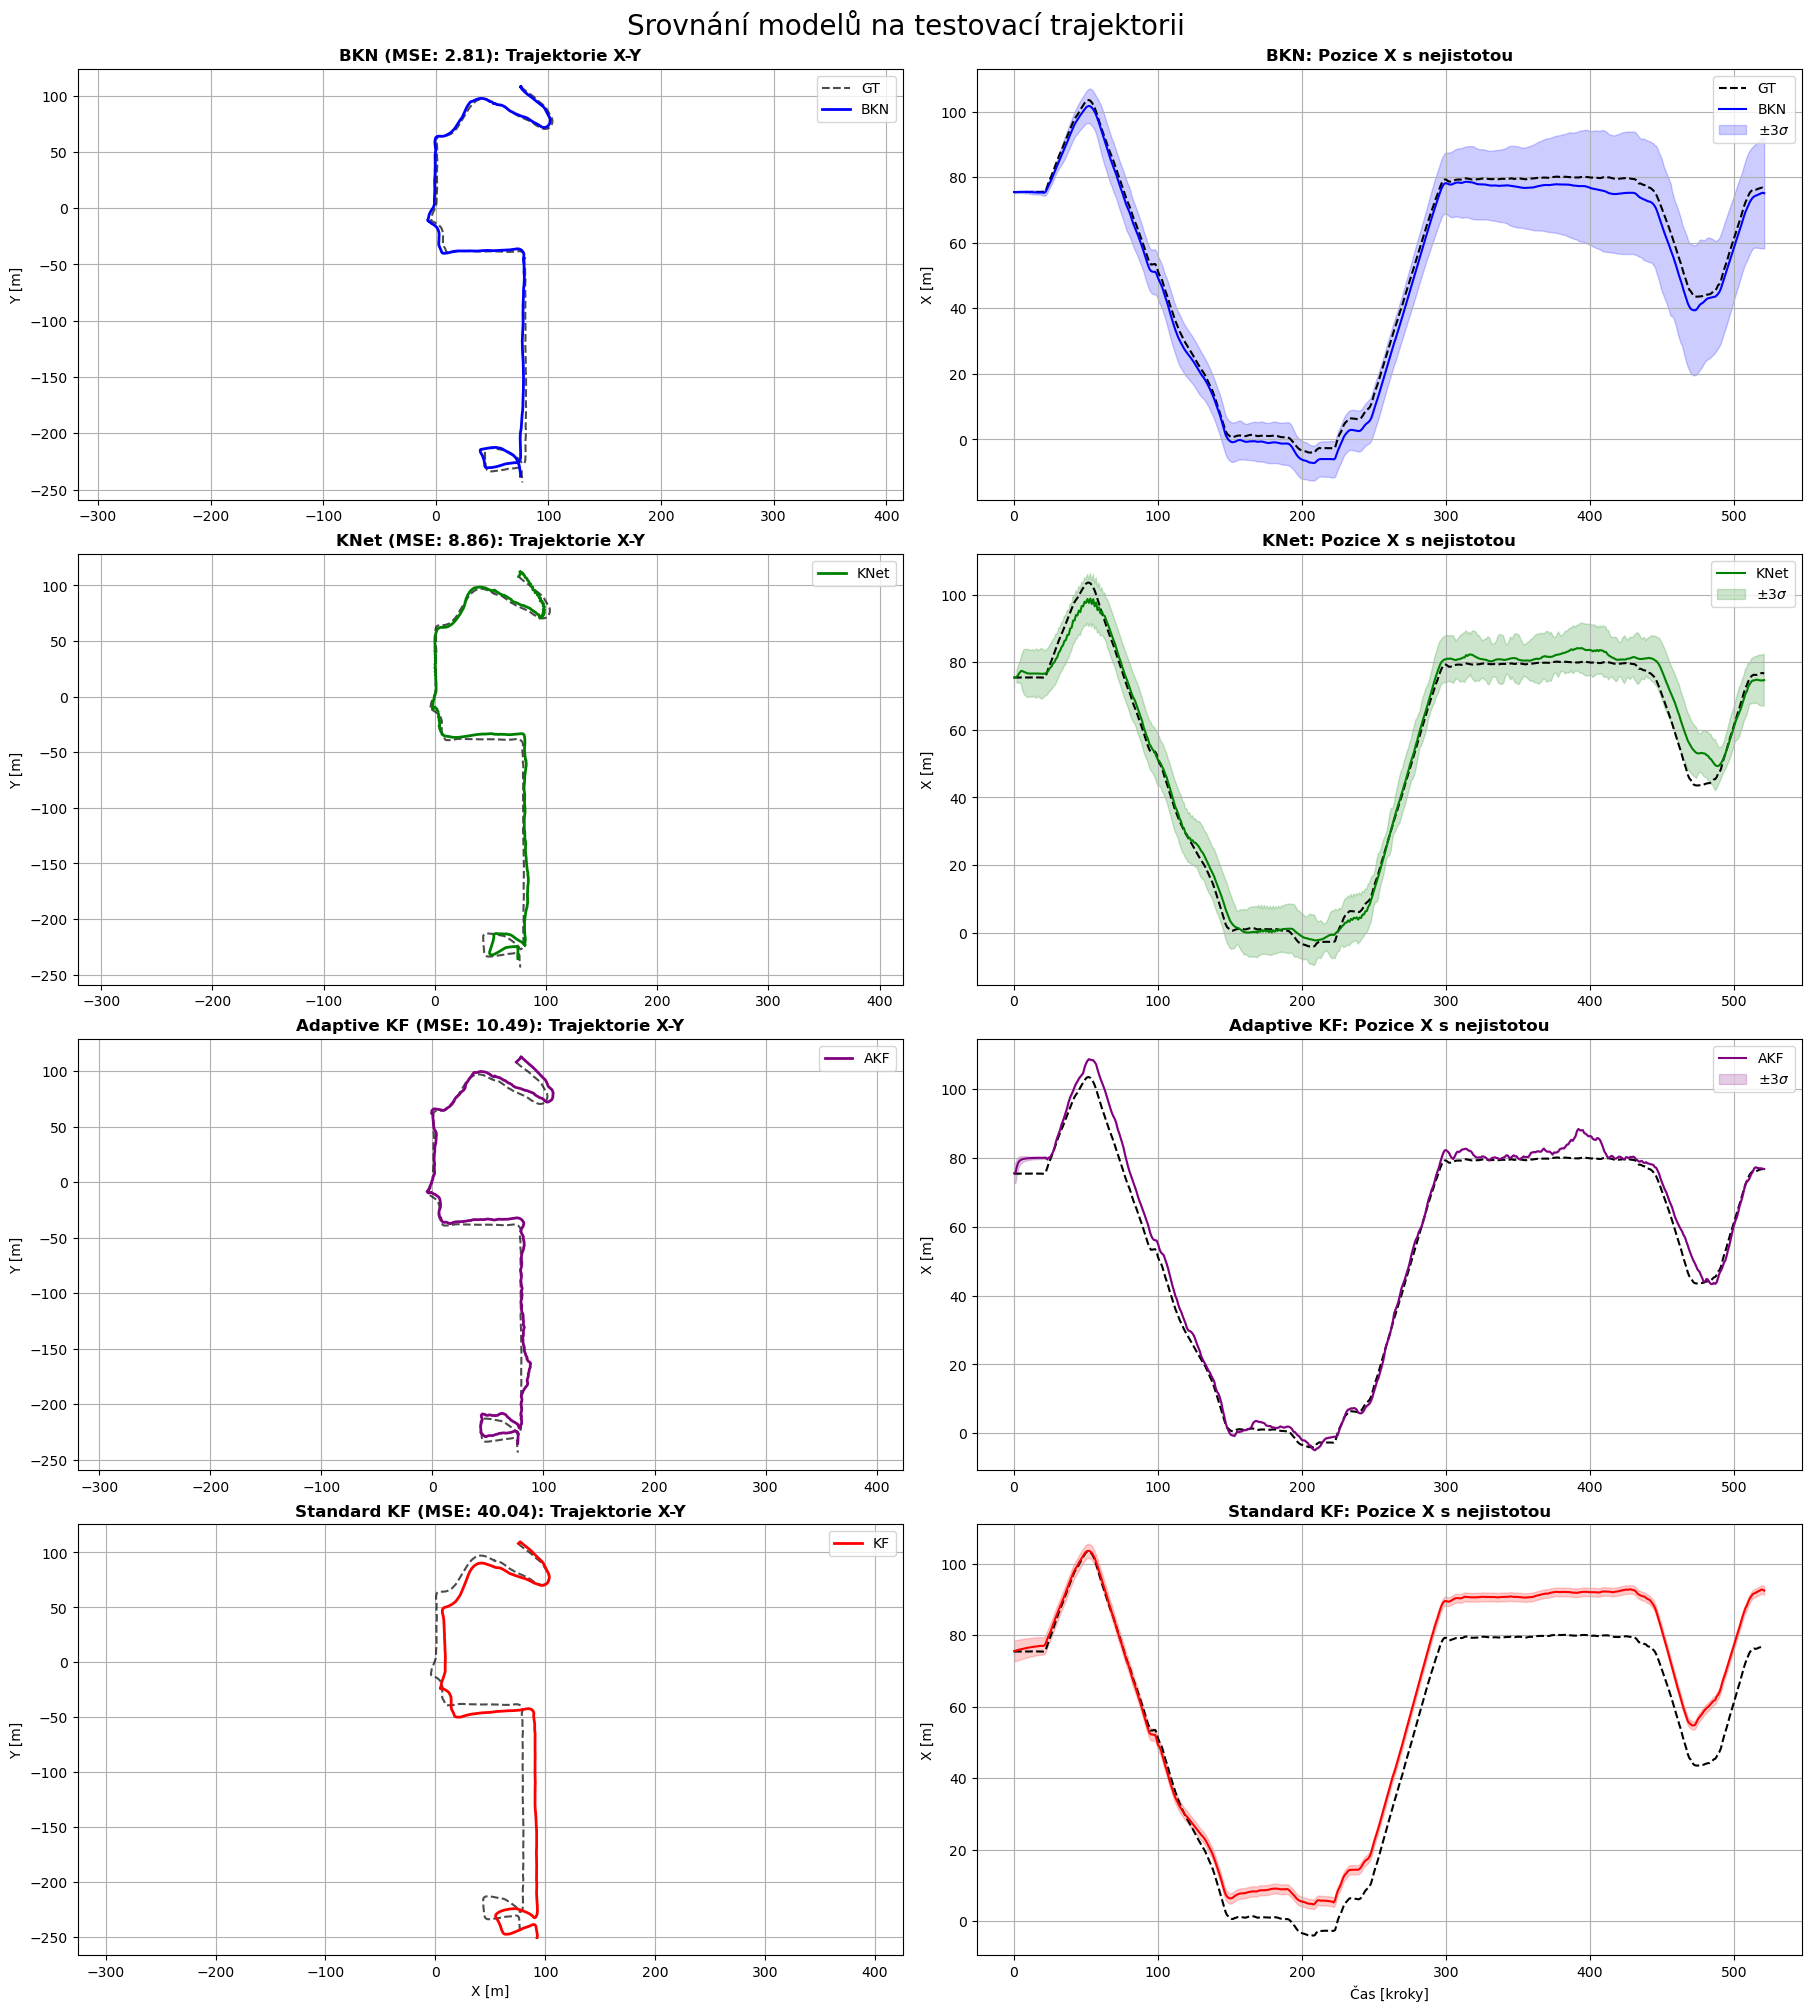

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# === 1. ZÍSKÁNÍ DAT PRO VIZUALIZACI (RE-RUN NA JEDNOM BATCHI) ===
# Musíme znovu spustit modely na jednom vzorku dat, abychom měli co kreslit.
x_true_batch, y_meas_batch = next(iter(test_loader))
i = 0 

y_seq = y_meas_batch[i].to(device)
x_true = x_true_batch[i].to(device)
seq_len = y_seq.shape[0]

# Inicializace
knet_init_state = x_true[0, :].unsqueeze(0)      # [1, 4]
filter_init_state = x_true[0, :].unsqueeze(1)    # [4, 1]

# !!! DŮLEŽITÉ: Vypnout počítání gradientů pro ušetření paměti !!!
with torch.no_grad():
    
    # --- A) BKN RUN ---
    ensemble_preds = []
    
    for j in range(J_SAMPLES):
        trained_model_bkn.reset(batch_size=1, initial_state=knet_init_state)
        # Ukládáme na CPU, abychom nehltili GPU paměť
        sample_seq = [knet_init_state.cpu()] 
        
        for t in range(1, seq_len):
            y_t = y_seq[t, :].unsqueeze(0)
            x_val, _ = trained_model_bkn.step(y_t) 
            # Okamžitě přesunout výsledek kroku na CPU
            sample_seq.append(x_val.cpu())
            
        # Spojíme sekvenci na CPU
        ensemble_preds.append(torch.cat(sample_seq, dim=0))

    # Nyní máme list tensorů na CPU, stackneme je
    ensemble_tensor = torch.stack(ensemble_preds, dim=0) # [J, Seq, Dim]
    
    # Průměr a varianci spočítáme na CPU (pro vizualizaci to stačí a je to bezpečné)
    x_hat_bkn = ensemble_tensor.mean(dim=0) 
    P_diag_bkn = ensemble_tensor.var(dim=0) + 1e-9

    # --- B) KNET RUN (Classic) ---
    if trained_model_classic is not None:
        trained_model_classic.reset(batch_size=1, initial_state=knet_init_state)
        
        # Ukládáme na CPU
        knet_preds = [knet_init_state.cpu()]
        
        P0_diag = torch.diagonal(sys_model.P0.cpu(), dim1=-2, dim2=-1).unsqueeze(0)
        knet_vars = [P0_diag]

        for t in range(1, seq_len):
            y_t = y_seq[t, :].unsqueeze(0)
            out = trained_model_classic.step(y_t)
            
            if isinstance(out, tuple): 
                x_val, P_val = out
                knet_preds.append(x_val.cpu())
                
                # Extrakce diagonály a přesun na CPU
                P_diag = torch.diagonal(P_val[0], dim1=-2, dim2=-1).unsqueeze(0).cpu()
                knet_vars.append(P_diag)
            else: 
                x_val = out
                knet_preds.append(x_val.cpu())
                knet_vars.append(torch.zeros_like(P0_diag))
        
        x_hat_knet = torch.cat(knet_preds, dim=0)
        knet_std_np = np.sqrt(torch.cat(knet_vars, dim=0).numpy()) # Už je na CPU
    else:
        x_hat_knet = None
        knet_std_np = None

    # --- C) AKF RUN (Adaptive KF) ---
    # Tento filtr vrací (results_dict, Q_hist, R_hist)
    res_akf_raw, _, _ = akf_filter.process_sequence_adaptively(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
    
    # --- D) KF RUN (Standard) ---
    res_kf = kf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)


# === 2. PŘÍPRAVA DAT PRO PLOTTING ===
# Převod na numpy
gt_np = x_true.cpu().numpy()
time_steps = np.arange(len(gt_np))

# BKN výsledky (už jsou na CPU)
bkn_est_np = x_hat_bkn.numpy()
bkn_std_np = np.sqrt(P_diag_bkn.numpy())

# AKF výsledky
akf_est_np = res_akf_raw['x_filtered'].detach().cpu().numpy()
akf_std_np = np.sqrt(np.diagonal(res_akf_raw['P_filtered'].detach().cpu().numpy(), axis1=1, axis2=2))

# KF výsledky
kf_est_np = res_kf['x_filtered'].detach().cpu().numpy()
kf_std_np = np.sqrt(np.diagonal(res_kf['P_filtered'].detach().cpu().numpy(), axis1=1, axis2=2))

if x_hat_knet is not None:
    knet_est_np = x_hat_knet.numpy()
else:
    knet_est_np = None

# === 3. VIZUALIZACE (4 řádky) ===
# Změna: 4 řádky místo 3
fig, axs = plt.subplots(4, 2, figsize=(18, 20), constrained_layout=True)

# Výpočet MSE pro titulky
mse_bkn = np.mean((bkn_est_np[1:] - gt_np[1:])**2)
mse_akf = np.mean((akf_est_np[1:] - gt_np[1:])**2)
mse_kf = np.mean((kf_est_np[1:] - gt_np[1:])**2)

fig.suptitle(f"Srovnání modelů na testovací trajektorii", fontsize=20)

# --- ŘÁDEK 1: Bayesian KalmanNet ---
axs[0, 0].plot(gt_np[:, 0], gt_np[:, 2], 'k--', label='GT', alpha=0.7)
axs[0, 0].plot(bkn_est_np[:, 0], bkn_est_np[:, 2], 'b-', linewidth=2, label='BKN')
axs[0, 0].set_title(f"BKN (MSE: {mse_bkn:.2f}): Trajektorie X-Y", fontweight='bold')
axs[0, 0].set_ylabel("Y [m]")
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].axis('equal')

axs[0, 1].plot(time_steps, gt_np[:, 0], 'k--', label='GT')
axs[0, 1].plot(time_steps, bkn_est_np[:, 0], 'b-', label='BKN')
axs[0, 1].fill_between(time_steps, 
                       bkn_est_np[:, 0] - 3*bkn_std_np[:, 0], 
                       bkn_est_np[:, 0] + 3*bkn_std_np[:, 0], 
                       color='blue', alpha=0.2, label='$\pm 3\sigma$')
axs[0, 1].set_title("BKN: Pozice X s nejistotou", fontweight='bold')
axs[0, 1].set_ylabel("X [m]")
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- ŘÁDEK 2: KNet (Classic) ---
if knet_est_np is not None:
    mse_knet = np.mean((knet_est_np[1:] - gt_np[1:])**2)
    axs[1, 0].plot(gt_np[:, 0], gt_np[:, 2], 'k--', alpha=0.7)
    axs[1, 0].plot(knet_est_np[:, 0], knet_est_np[:, 2], 'g-', linewidth=2, label='KNet')
    axs[1, 0].set_title(f"KNet (MSE: {mse_knet:.2f}): Trajektorie X-Y", fontweight='bold')
    axs[1, 0].set_ylabel("Y [m]")
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    axs[1, 0].axis('equal')

    axs[1, 1].plot(time_steps, gt_np[:, 0], 'k--')
    axs[1, 1].plot(time_steps, knet_est_np[:, 0], 'g-', label='KNet')
    axs[1, 1].fill_between(time_steps, 
                           knet_est_np[:, 0] - 3*knet_std_np[:, 0], 
                           knet_est_np[:, 0] + 3*knet_std_np[:, 0], 
                           color='green', alpha=0.2, label='$\pm 3\sigma$')
    axs[1, 1].set_title("KNet: Pozice X s nejistotou", fontweight='bold')
    axs[1, 1].set_ylabel("X [m]")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

# --- ŘÁDEK 3: Adaptive KF (AKF) - NOVÉ ---
axs[2, 0].plot(gt_np[:, 0], gt_np[:, 2], 'k--', alpha=0.7)
axs[2, 0].plot(akf_est_np[:, 0], akf_est_np[:, 2], color='purple', linewidth=2, label='AKF')
axs[2, 0].set_title(f"Adaptive KF (MSE: {mse_akf:.2f}): Trajektorie X-Y", fontweight='bold')
axs[2, 0].set_ylabel("Y [m]")
axs[2, 0].legend()
axs[2, 0].grid(True)
axs[2, 0].axis('equal')

axs[2, 1].plot(time_steps, gt_np[:, 0], 'k--')
axs[2, 1].plot(time_steps, akf_est_np[:, 0], color='purple', label='AKF')
axs[2, 1].fill_between(time_steps, 
                       akf_est_np[:, 0] - 3*akf_std_np[:, 0], 
                       akf_est_np[:, 0] + 3*akf_std_np[:, 0], 
                       color='purple', alpha=0.2, label='$\pm 3\sigma$')
axs[2, 1].set_title("Adaptive KF: Pozice X s nejistotou", fontweight='bold')
axs[2, 1].set_ylabel("X [m]")
axs[2, 1].legend()
axs[2, 1].grid(True)

# --- ŘÁDEK 4: Standard KF ---
axs[3, 0].plot(gt_np[:, 0], gt_np[:, 2], 'k--', alpha=0.7)
axs[3, 0].plot(kf_est_np[:, 0], kf_est_np[:, 2], 'r-', linewidth=2, label='KF')
axs[3, 0].set_title(f"Standard KF (MSE: {mse_kf:.2f}): Trajektorie X-Y", fontweight='bold')
axs[3, 0].set_xlabel("X [m]")
axs[3, 0].set_ylabel("Y [m]")
axs[3, 0].legend()
axs[3, 0].grid(True)
axs[3, 0].axis('equal')

axs[3, 1].plot(time_steps, gt_np[:, 0], 'k--')
axs[3, 1].plot(time_steps, kf_est_np[:, 0], 'r-', label='KF')
axs[3, 1].fill_between(time_steps, 
                       kf_est_np[:, 0] - 3*kf_std_np[:, 0], 
                       kf_est_np[:, 0] + 3*kf_std_np[:, 0], 
                       color='red', alpha=0.2, label='$\pm 3\sigma$')
axs[3, 1].set_title("Standard KF: Pozice X s nejistotou", fontweight='bold')
axs[3, 1].set_xlabel("Čas [kroky]")
axs[3, 1].set_ylabel("X [m]")
axs[3, 1].grid(True)

plt.show()